<a href="https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyLatheDB - A Library for Relational Keyword Search with Support to Schema References
---

PyLatheDB is based on Lathe, an R-KwS framework that generalizes the well-known concepts of Query Matches (QMs) and Candidate Joining Networks (CJNs) to handle keywords referring to schema elements and introduces new algorithms to generate them, along with a novel approach to automatically select the CJNs that are more likely to represent the user intent when issuing a keyword query.

We recommend running this Python Notebook using [Google Colab](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb). But its static version is also available in our [GitHub Repository](https://github.com/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb).

## Environment Preparation

Initially, before the demonstration, it is necessary to  run an environment preparation step, which includes the installation of the RDBMS; the downloading of some configuration files and scripts; and the installation of the **PyLatheDB** library and its dependencies.

### Download of the configuration Files

The configuration files comprise information about the datasets and query sets used. They are automatically downloaded, but they can also be found [here](https://drive.google.com/drive/folders/1Xz3mPN0NC7xdIETKZlFDTcqcU6lsVUYD?usp=sharing).

In [1]:
!gdown --id 1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
!unzip PyLatheDB_DEMO_resources.zip
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
!cp dbsources/pylathedb.stop /usr/share/postgresql/10/tsearch_data/english.stop

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
To: /content/PyLatheDB_DEMO_resources.zip
100% 92.3M/92.3M [00:00<00:00, 187MB/s]
Archive:  PyLatheDB_DEMO_resources.zip
   creating: datasets/
   creating: datasets/imdb/
  inflating: datasets/imdb/imdb_schema_index_file.shelve.db  
  inflating: datasets/imdb/imdb_schema_graph_file.pickle  
  inflating: datasets/imdb/imdb_value_index_file.shelve.db  
   creating: datasets/mondial/
  inflating: datasets/mondial/mondial_schema_graph_file.pickle  
  inflating: datasets/mondial/mondial_schema_index_file.shelve.db  
  inflating: datasets/mondial/mondial_value_index_file.shelve.db  
   creating: querysets/
  inflating: querysets/coffman_imdb.json  
  inflating: querysets/coffman_mondial

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


cp: cannot create regular file '/usr/share/postgresql/10/tsearch_data/english.stop': No such file or directory


### Installation of the PostgreSQL

In [2]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-contrib &>log
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"


 * Starting PostgreSQL 10 database server
   ...done.
ALTER ROLE


### Scripts for the Databases Creation

In [3]:
!sudo -u postgres dropdb imdb &>>log
!sudo -u postgres createdb imdb &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-schema.pgsql &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-data.pgsql &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-fulltext_index.psql &>>log
!sudo -u postgres psql -U postgres imdb < dbsources/imdb-rename-tables.psql &>>log

!sudo -u postgres dropdb mondial &>>log
!sudo -u postgres createdb mondial &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part1.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-data.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part2.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-field_fulltext_index.psql &>>log

### Enable DataTable Formating from Google Colab

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

### Installation of the PyLathe library available [here](https://pypi.org/project/pylathedb/)

In [5]:
!pip install pylathedb==1.0.3 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 3.0 MB 9.0 MB/s 


## PyLatheDB setup

In this section, we will run the PyLatheDB setup, which comprises the creation of the Value Index and the Schema Index. We will also explain the main parameters of the library, such as number of QMs, number of CJNs per QM and the use of the eager evaluation strategy for CJN generation. 

### Library import and set configuration directory

In [6]:
from pylathedb.lathe import Lathe
lathe = Lathe(config_directory='./config/')

### Create Indexes 
This step is not necessary because we already downloaded the indexes alongside the configuration files. But feel free to test the Index Creation by uncommenting the following cell:

In [7]:
# lathe.create_indexes()

### Load Indexes

The cell below shows how to load the Value and Schema Indexes.

In [8]:
lathe.load_indexes()

### Choose Query set/Database

You can choose which query set to use and its respective database. Input as a function parameter the number of the name of the query set to use. If you input no number, it will list the query sets available.

In [9]:
lathe.change_queryset()

Please input a query set to change:
01 - coffman_imdb
02 - coffman_mondial


In [10]:
lathe.change_queryset('coffman_imdb')

./config/queryset_configs/coffman_imdb_config.json
Changed to query set coffman_imdb.


### Default Parameters

We have a few parameters for R-KwS using PyLatheDB:
*    `max_qm_size`: Maximum Query Match Size
*    `max_cjn_size`: Maximum Candidate Joining Network Size
*    `topk_cns`: Top-k CJNs to be considered
*    `configuration`: A tuple containing the number of QMs to be considered, number of CJNs for each QM to be considered, and the maximum number of CJNs to be probed by the eager evaluation for each QM. 




In [11]:
lathe.max_qm_size = 3
lathe.max_cjn_size = 5
lathe.topk_cns = 10
lathe.configuration = (5,1,9)

## Keyword Search over Relational Databases

You can use the function `keyword_search` from the class `Lathe` using three parameters. 


1.   You can input a Keyword query
2.   You can call the function with no input to show a list of premade keyword queries used in Coffman Benchmark.
3.   You can input the number of the keyword query according to the option 2.

In [12]:
lathe.keyword_search()

Please input a keyword query or choose one of the queries below:
01 - denzel washington
02 - clint eastwood
03 - john wayne
04 - will smith
05 - harrison ford
06 - julia roberts
07 - tom hanks
08 - johnny depp
09 - angelina jolie
10 - morgan freeman
11 - gone with the wind
12 - star wars
13 - casablanca
14 - lord of the rings
15 - the sound of music
16 - wizard of oz
17 - the notebook
18 - forrest gump
19 - the princess bride
20 - the godfather
21 - title atticus finch
22 - title indiana jones
23 - title james bond
24 - title rick blaine
25 - title will kane
26 - title dr. hannibal lecter
27 - title norman bates
28 - title darth vader
29 - title the wicked witch of the west
30 - title nurse ratched
31 - title frankly my dear i don't give a damn
32 - title i'm going to make him an offer he can't refuse
33 - title you don't understand i coulda had class i coulda been a contender i coulda been somebody instead of a bum which is what i am
34 - title toto i've a feeling we're not in kansas 

### Understanding the Results

The function `keyword_search` from the class `Lathe` returns an `LatheResult` object, which contains methods to show the CJNs, QMs and KMs returned for the keyword query.

#### Candidate Joining Networks

The library returns, for each CJN, its Text representation, its Graph representation, its SQL translation and the returned results from the SQL execution by the RDBMS. The function `cjns` outputs the informatio about each CJN according to four boolean parameters: `text`, `graph`, `sql`, and `jnts`. All of them are enabled by default.


*The Graph representation may not be available in the static version of this notebook in Github. You can run it using Google Colab [here](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb).*

Keyword Query: julia roberts films


---

**1st CJN**:

---

Text:
	PERSON.v(name{julia,roberts})
		<CASTING
			>MOVIE.s(*{films})


---

Graph:


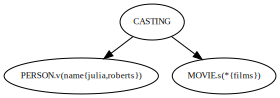

---

SQL:
  
  SELECT
  	t1.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


name      id                       title imdb_index  kind_id  \
0  Roberts, Julia    3161                20 Something       None        1   
1  Roberts, Julia  175564                   Firehouse       None        1   
2  Roberts, Julia  198621              Grand Champion       None        1   
3  Roberts, Julia  304918  Ljuset håller mig sällskap       None        1   
4  Roberts, Julia  422036               Runaway Bride       None        1   

   year imdb_id phonetic_code episode_of_id season_nr episode_nr series_years  \
0  2006    None         S5352          None      None       None         None   
1  1987    None           F62          None      None       None         None   
2  2002    None         G6532          None      None       None         None   
3  2000    None         L2346          None      None       None         None   
4  1999    None         R5163          None      None       None         None   

   __search_id  
0     43788412  
1     43846816  
2     43876968  
3     44099445  
4     44164278

---

**2nd CJN**:

---

Text:
	MOVIE.s(*{films}).v(title{julia,roberts})


---

Graph:


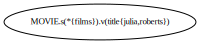

---

SQL:
  
  SELECT
  	t1.title,
  	t1.*
  FROM
  	movie t1
  WHERE
  	t1.title_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


title      id  \
0  Untitled Julia Roberts/Joan Root Project  567842   

                                      title imdb_index  kind_id  year imdb_id  \
0  Untitled Julia Roberts/Joan Root Project       None        1  2009    None   

  phonetic_code episode_of_id season_nr episode_nr series_years  __search_id  
0         U5343          None      None       None         None     44309348

---

**3rd CJN**:

---

Text:
	MOVIEINFO.v(info{julia,roberts})
		>MOVIE.s(*{films})


---

Graph:


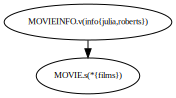

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	movieinfo t1
  	JOIN movie t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('julia & roberts')
  LIMIT 1000;



---

JNTs:


id           title imdb_index  kind_id  year imdb_id phonetic_code  \
0  263267  Kiss the Bride       None        1  2007    None         K2316   
1  364762  Ocean's Twelve       None        1  2004    None         O2523   
2  364762  Ocean's Twelve       None        1  2004    None         O2523   
3  364762  Ocean's Twelve       None        1  2004    None         O2523   
4  523654    The Prestige       None        1  2006    None         P6232   

  episode_of_id season_nr episode_nr series_years  __search_id  \
0          None      None       None         None     43995987   
1          None      None       None         None     44054612   
2          None      None       None         None     44054612   
3          None      None       None         None     44054612   
4          None      None       None         None     44264635   

                                                info  
0  Stephanie: You totally love him. You want to w...  
1  [to Tess while she is pretending to be Julia R...  
2  Tess Ocean: [while trying to get through a cro...  
3  Tess Ocean: Ma Marcus?::Julia Roberts: Um... N...  
4  Julia McCullough: I thought up a name for you:...

---

**4th CJN**:

---

Text:
	PERSON.v(name{julia})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{roberts})


---

Graph:


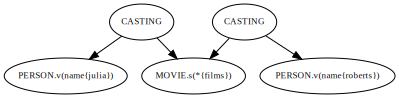

---

SQL:
  
  SELECT
  	t1.name,
  	t5.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  	JOIN casting t4 ON t4.movie_id = t3.id
  	JOIN person t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('julia')
  	AND t5.name_tsvector @@ to_tsquery('roberts')
  LIMIT 1000;



---

JNTs:


name             name      id         title imdb_index  \
0           Julia, Raul   Harvey, Robert  527311    The Rookie       None   
1           Julia, Raul    Dubac, Robert  527311    The Rookie       None   
2  Gordon, Julia Swayne    Ellis, Robert  114233  Dark Secrets       None   
3           Boyd, Julia   Watzke, Robert  136518      Dispatch       None   
4           Boyd, Julia  Roberts, Arthur  136518      Dispatch       None   

   kind_id  year imdb_id phonetic_code episode_of_id season_nr episode_nr  \
0        1  1990    None            R2          None      None       None   
1        1  1990    None            R2          None      None       None   
2        1  1923    None         D6263          None      None       None   
3        1  2009    None         D2132          None      None       None   
4        1  2009    None         D2132          None      None       None   

  series_years  __search_id  
0         None     44275854  
1         None     44275854  
2         None     43885272  
3         None     43911170  
4         None     43911170

---

**5th CJN**:

---

Text:
	PERSON.v(name{julia,roberts})
		<CASTING
			>CHARACTER
				<CASTING
					>MOVIE.v(title{films})


---

Graph:


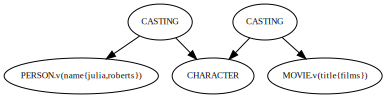

---

SQL:
  
  SELECT
  	t1.name,
  	t5.title
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN character t3 ON t2.person_role_id = t3.id
  	JOIN casting t4 ON t4.person_role_id = t3.id
  	JOIN movie t5 ON t4.movie_id = t5.id
  WHERE
  	t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('julia & roberts')
  	AND t5.title_tsvector @@ to_tsquery('films')
  LIMIT 1000;



---

JNTs:


name                                              title
0  Roberts, Julia                             The Film That Was Lost
1  Roberts, Julia  Going to Pieces: The Rise and Fall of the Slas...
2  Roberts, Julia  Going to Pieces: The Rise and Fall of the Slas...
3  Roberts, Julia              The Fantasy Film Worlds of George Pal
4  Roberts, Julia                        The Making of a Horror Film

In [13]:
result = lathe.keyword_search('julia roberts films')
result.cjns()

### Query Matches

The function `qms` returns a ranked list of the Query Matches for the keyword query. Each QM is presented as a set of Keyword Matches.

In [14]:
result.qms()

---

**1st QM**:

---

{MOVIE.s(*{films}), PERSON.v(name{julia,roberts})}


---

**2nd QM**:

---

{MOVIE.s(*{films}).v(title{julia,roberts})}


---

**3rd QM**:

---

{MOVIEINFO.v(info{julia,roberts}), MOVIE.s(*{films})}


---

**4th QM**:

---

{PERSON.v(name{roberts}), MOVIE.s(*{films}), PERSON.v(name{julia})}


---

**5th QM**:

---

{MOVIE.v(title{films}), PERSON.v(name{julia,roberts})}


### Keyword Matches

The function `kms` returns two unordered lists, one for the Schema-Keyword Matches and one for Value-Keyword Matches.

In [15]:
result.kms()

---

**SKMs**:

---

MOVIE.s(*{films})


---

**VKMs**:

---

MOVIEINFO.v(info{julia})
PERSON.v(name{julia})
CHARACTER.v(name{julia})
MOVIE.v(title{julia})
MOVIEINFO.v(info{roberts})
PERSON.v(name{roberts})
CHARACTER.v(name{roberts})
MOVIE.v(title{roberts})
MOVIEINFO.v(info{films})
CHARACTER.v(name{films})
MOVIE.v(title{films})
MOVIEINFO.v(info{julia,roberts})
MOVIEINFO.v(info{julia,films})
PERSON.v(name{julia,roberts})
MOVIE.v(title{julia,roberts})


Keyword Query: john travolta olivia films


---

**1st CJN**:

---

Text:
	PERSON.v(name{travolta,john})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{olivia,john})


---

Graph:


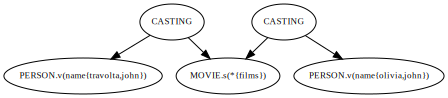

---

SQL:
  
  SELECT
  	t1.name,
  	t5.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  	JOIN casting t4 ON t4.movie_id = t3.id
  	JOIN person t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('travolta & john')
  	AND t5.name_tsvector @@ to_tsquery('olivia & john')
  LIMIT 1000;



---

JNTs:


name                 name      id          title imdb_index  \
0  Travolta, John  Newton-John, Olivia  199214         Grease       None   
1  Travolta, John  Newton-John, Olivia  559385  Two of a Kind       None   
2  Travolta, John  Newton-John, Olivia  504851       The Guru       None   

   kind_id  year imdb_id phonetic_code episode_of_id season_nr episode_nr  \
0        1  1978    None           G62          None      None       None   
1        1  1983    None         T1253          None      None       None   
2        1  2002    None            G6          None      None       None   

  series_years  __search_id  
0         None     43908386  
1         None     44303665  
2         None     44255543

---

**2nd CJN**:

---

Text:
	MOVIEINFO.v(info{travolta,olivia,john})
		>MOVIE.s(*{films})


---

Graph:


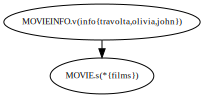

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	movieinfo t1
  	JOIN movie t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('travolta & olivia & john')
  LIMIT 1000;



---

JNTs:


id                   title imdb_index  kind_id  year imdb_id  \
0  510494  The Last Days of Disco       None        1  1998    None   

  phonetic_code episode_of_id season_nr episode_nr series_years  __search_id  \
0         L2321          None      None       None         None     44283571   

                                                info  
0  Josh Neff: Disco will never be over. It will a...

In [16]:
results = lathe.keyword_search('john travolta olivia films')
results.cjns()

In [17]:
results = lathe.keyword_search(38)
results.cjns(text=True,graph=False,sql=True,df=False)

Keyword Query: henry fonda yours mine ours character


---

**1st CJN**:

---

Text:
	PERSON.v(name{fonda,henry})
		<CASTING
			>ROLE.s(*{character})
			>MOVIE.v(title{mine})


---

SQL:
  
  SELECT
  	t3.title,
  	t1.name,
  	t4.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN role t4 ON t2.role_id = t4.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('fonda & henry')
  	AND t3.title_tsvector @@ to_tsquery('mine')
  LIMIT 1000;


